# Grain sizes counting and distribution testing

## Preprocessing

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# import ipympl
import imageio.v3 as iio
import skimage
import warnings
warnings.filterwarnings("ignore")


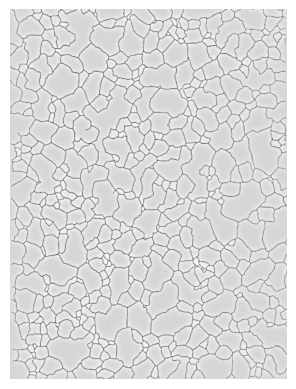

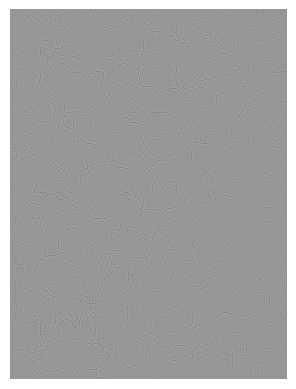

(1861, 1393)


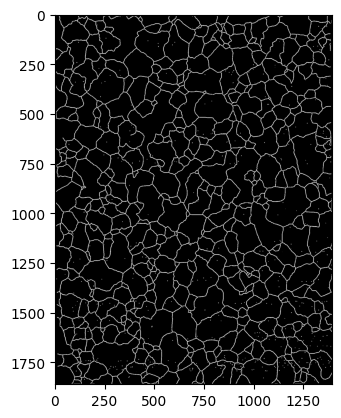

In [16]:
from skimage.filters import gaussian, median, difference_of_gaussians, laplace
from skimage.feature import canny
from skimage import exposure

image_original = iio.imread(uri="data/structures/S2.png")

# fig = plt.figure()
# fig.add_subplot(2, 2, 1)
# plt.imshow(image_original)
# # print(image)
# # image_original.shape
# gray_image = skimage.color.rgb2gray(image_original)
# fig.add_subplot(2, 2, 2)
# plt.imshow(gray_image)
# filtered_image = median(gray_image)
# fig.add_subplot(2, 2, 3)
# plt.imshow(filtered_image)
# image_canny = canny(filtered_image, 1.5)
# image = image_canny.copy()
# fig.add_subplot(2, 2, 4)
# plt.imshow(image, cmap='gray')
# plt.show(block=True)

def preprocess_image(original_image, verbose=True):
    gray_image = skimage.color.rgb2gray(original_image)
    # fig, ax = plt.subplots()
    # plt.axis('off')
    # plt.imshow(gray_image, cmap='gray')
    filtered_image = difference_of_gaussians(gray_image, 1, 12)
    if verbose:
        fig, ax = plt.subplots()
        plt.axis('off')
        plt.imshow(filtered_image, cmap='gray')
    image_edges = laplace(filtered_image, 8)
    image = image_edges.copy()
    if verbose:
        fig, ax = plt.subplots()
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.autoscale(tight=True)
        plt.show()

    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    img_eq = exposure.equalize_hist(image)
    img_eq[img_eq>0.25] = 1
    img_eq[img_eq<=0.25] = 0
    img_eq = 1 - img_eq
    if verbose:
        fig, ax = plt.subplots()
        plt.imshow(img_eq, cmap='gray')
    image = img_eq
    print(image.shape)
    return image

image = preprocess_image(image_original)

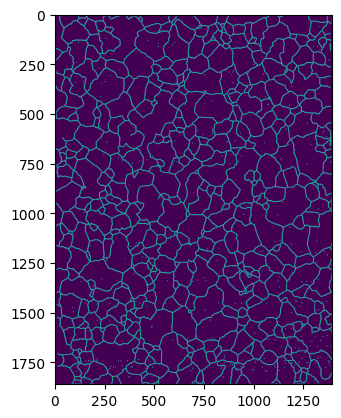

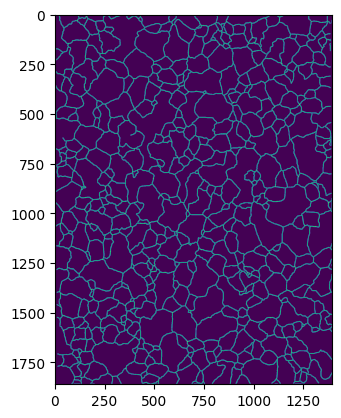

In [17]:
def remove_islands(image, kernel_size=5):
    kernel = np.zeros((kernel_size, kernel_size), np.uint8)
    kernel[:,0] = 1
    kernel[0,:] = 1
    kernel[:,-1] = 1
    kernel[-1,:] = 1
    # print(kernel)


    for i in range(0, image.shape[0]-kernel_size):
        for j in range(0, image.shape[1]-kernel_size):
            border = image[i:i+kernel_size, j:j+kernel_size]
            if((border*kernel).sum() == 0):
                image[i:i+kernel_size, j:j+kernel_size] = 0

remove_islands(image)
fig, ax = plt.subplots()
plt.imshow(image)
remove_islands(image, 10)
fig, ax = plt.subplots()
plt.imshow(image)

## Applicaion

### Grain sizes collecting

(array([18., 10., 10., 12., 14.,  5., 13., 12., 13., 13., 18.,  8.,  9.,
         7., 14., 16.,  8., 10., 21., 11.,  9., 11., 14., 13., 14., 14.,
        12., 13., 13.,  8., 13., 14., 14., 14.,  8., 11.,  6.,  8.,  0.,
        18., 10.,  6.,  8., 12.,  5.,  9.,  4., 10., 11., 12., 15., 18.,
         6., 11., 11., 12.,  6., 20.,  4.,  8., 12., 13., 11.,  3., 13.,
         6.,  5.,  6., 10.,  9., 12.,  7.,  8.,  7.,  6.,  7.,  8.,  0.,
         9.,  5.,  3.,  6.,  7.,  2.,  5.,  2.,  5.,  3.,  4.,  6.,  7.,
         2.,  3.,  5.,  1.,  4.,  5.,  2.,  4.,  2.,  3.,  5.,  2.,  3.,
         2.,  2.,  3.,  0.,  2.,  2.,  3.,  1.,  1.,  2.,  3.,  4.,  0.,
         2.,  2.,  5.,  1.,  1.,  2.,  2.,  1.,  2.,  1.,  3.,  2.,  0.,
         4.,  3.,  2.,  4.,  0.,  1.,  0.,  5.,  1.,  1.,  0.,  2.,  0.,
         2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  2.,  1.,  0.,  1.,
         0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.

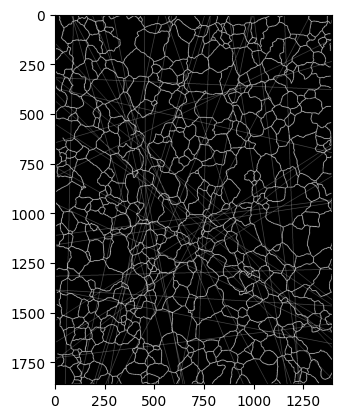

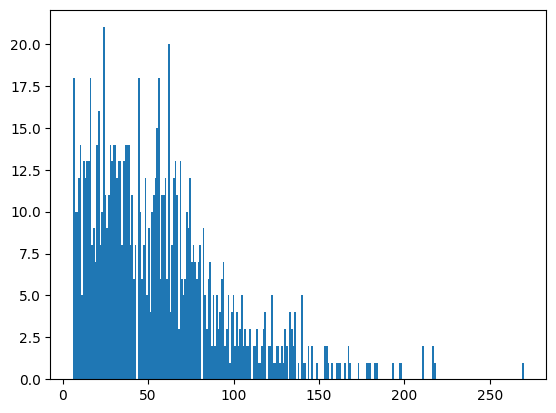

In [18]:
from skimage.draw import line
import random

def get_grains(pixels):
    peaks = pixels.copy()
    for i in range(3, len(pixels)-3):
        if not pixels[i] and pixels[i-1] and not pixels[i-2] and pixels[i+1] and not pixels[i+2]:
            peaks[i] = True
        else:
            if pixels[i] and not pixels[i-1] and pixels[i-2] and not pixels[i+1] and pixels[i+2]:
                peaks[i] = False
    peaks = np.flip(peaks)
    grains = []
    curr_len = 0
    for i in range(len(peaks)):
        if peaks[i]:
            if curr_len > 0:
                grains.append(curr_len)
            curr_len = 0
        else:
            curr_len += 1
    return grains

def collect_grains(image):
    cuts_illustration = np.zeros(image.shape, np.uint8)
    cuts_illustration = image.copy()
    grains = []
    desired_size = 1000
    grain_border_width = 5
    pseudorandomizer = np.random.RandomState(2021)
    while len(grains) < desired_size:
        rand_r1 = random.randrange(image.shape[0])
        rand_c1 = random.randrange(image.shape[1])
        rand_r2 = random.randrange(image.shape[0])
        rand_c2 = random.randrange(image.shape[1])
        if pseudorandomizer.randint(0, 1000) < 500:
            rr, cc = line(rand_r1, 0, rand_r2, image.shape[1]-1)
        else:
            rr, cc = line(0, rand_c1, image.shape[0]-1, rand_c2)
        curr_line_pixels = image[rr, cc]
        cuts_illustration[rr, cc] = 1
        grain_candidates = get_grains(curr_line_pixels)
        for grain in grain_candidates:
            if grain > grain_border_width:
                grains.append(grain)
    return grains, cuts_illustration

grains, cuts_illustration = collect_grains(image)
fig, ax = plt.subplots()
plt.imshow(cuts_illustration, cmap='gray')
fig, ax = plt.subplots()
grains = np.array(grains)
bins = max(grains) + 1
plt.hist(grains, density=False, bins=bins)


In [19]:
from scipy import stats

stats.describe(grains)

DescribeResult(nobs=1018, minmax=(6, 270), mean=56.209233791748524, variance=1524.3308094418462, skewness=1.2907123634830617, kurtosis=2.278835967054367)

### Grain sizes distribution testing

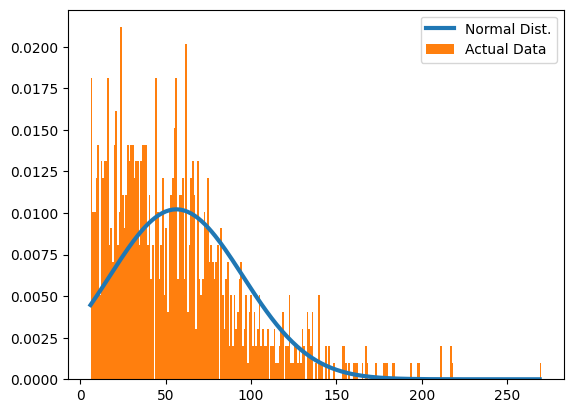


Normaltest p-value is: 0.00 

We have evidence to reject the null hypothesis.


In [20]:
import scipy.stats as stats

def check_p_val(p_val, alpha):
    if p_val < alpha:
        print('We have evidence to reject the null hypothesis.')
    else:
        print('We do not have evidence to reject the null hypothesis.')

xs = np.arange(grains.min(), grains.max(), 1)
params = stats.norm.fit(grains)
fit = stats.norm.pdf(xs, *params)
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()
plt.show()

stat, p_val = stats.normaltest(grains)
print('\nNormaltest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

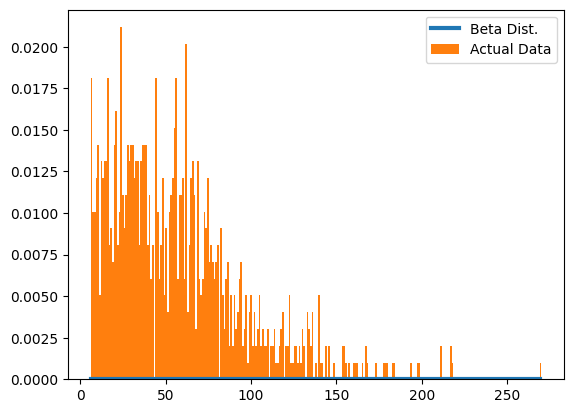


KStest p-value is: 0.00 

We have evidence to reject the null hypothesis.


In [21]:
params = stats.f.fit(grains)
fit = stats.beta.pdf(xs, *params)
plt.plot(xs, fit, label='Beta Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()
plt.show()

stat, p_val = stats.kstest(grains, 'f', args=params)
print('\nKStest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

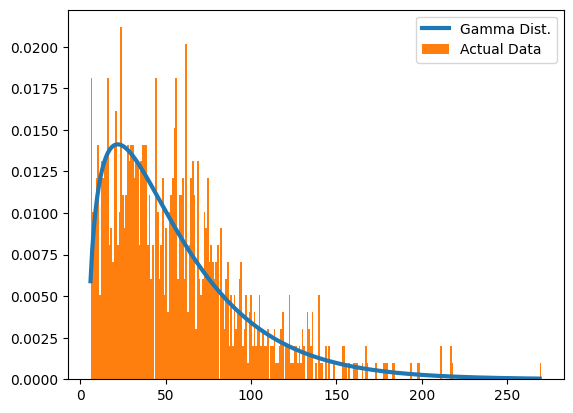


KStest p-value is: 0.00 

We have evidence to reject the null hypothesis.


In [22]:
params = stats.erlang.fit(grains)
fit = stats.gamma.pdf(xs, *params)
plt.plot(xs, fit, label='Gamma Dist.', lw=3)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend()
plt.show()

stat, p_val = stats.kstest(grains, 'erlang', args=params)
print('\nKStest p-value is: {:1.2f} \n'.format(p_val))
check_p_val(p_val, alpha=0.05)

In [23]:
import scipy.stats as st

dist_names = ["norm", "lognorm", "alpha", "beta", "gamma", "expon", "exponnorm", "t", "erlang", "f"]

def get_best_distribution(data):
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

best_dist, best_p, best_params = get_best_distribution(grains)


p value for norm = 3.7119399373317197e-09
p value for lognorm = 0.0038206499055827322
p value for alpha = 5.852011881433312e-30
p value for beta = 0.039765441793443324
p value for gamma = 0.003825846165525759
p value for expon = 7.344049009597488e-09
p value for exponnorm = 2.670214061149557e-06
p value for t = 1.6352428293555502e-09
p value for erlang = 0.0038261840059005733
p value for f = 0.003667096400554664
Best fitting distribution: beta
Best p value: 0.039765441793443324
Parameters for the best fit: (1.1798061089997414, 6.726670254690028, 5.719998054670036, 337.40387071999737)


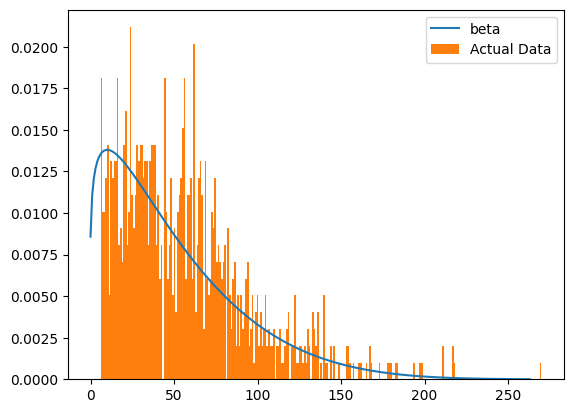

In [24]:
def illustrate_best_fit(dist_name, params):
    dist = getattr(st, dist_name)
    pdf_fitted = dist.pdf(xs, *params)
    plt.plot(pdf_fitted, label=dist_name)
    plt.hist(grains, bins, density=True, label='Actual Data')
    plt.legend(loc='upper right')
    plt.show()

illustrate_best_fit(best_dist, best_params)

In [25]:
def best_fit_moments(best_dist, best_params):
    dist = getattr(st, best_dist)
    (m, v, s, k) = dist.stats(*best_params, moments='mvsk')
    print('Mean and variance, calculated from best fit distribution parameters:')
    print(m)
    print(v)

best_fit_moments(best_dist, best_params)

Mean and variance, calculated from best fit distribution parameters:
56.06747644640221
1622.7029545462717


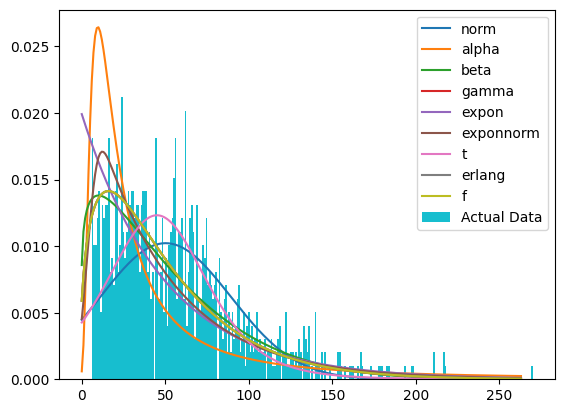

In [26]:
xs = np.arange(grains.min(), grains.max(), 1)
dist_names = ["norm", "alpha", "beta", "gamma", "expon", "exponnorm", "t", "erlang", "f"]

for dist_name in dist_names:
    dist = getattr(st, dist_name)
    params = dist.fit(grains)
    pdf_fitted = dist.pdf(xs, *params)
    plt.plot(pdf_fitted, label=dist_name)
plt.hist(grains, bins, density=True, label='Actual Data')
plt.legend(loc='upper right')
plt.show()

### Process samples

In [27]:
samples = [
 "data/structures/S1.png",
 "data/structures/S2.png",
 "data/structures/S3.png",
 "data/structures/S4.png",
 "data/structures/S5.png",
 "data/structures/S6.png",
 "data/structures/S7.png",
]

Processing: data/structures/S1.png
(1605, 1141)


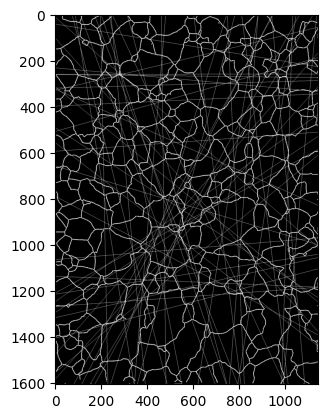

DescribeResult(nobs=1021, minmax=(6, 329), mean=68.29382957884427, variance=2258.5547560062223, skewness=1.2116497396624353, kurtosis=2.2520507736544566)
p value for norm = 1.9034676362872886e-08
p value for alpha = 1.9478737542193587e-47
p value for beta = 0.02129119297482355
p value for gamma = 0.02129152642227934
p value for expon = 1.9775562326767038e-10
p value for exponnorm = 2.9019202175718613e-11
p value for t = 1.9050006221221035e-08
p value for erlang = 0.021290875236299432
p value for f = 0.020571745408316584
Best fitting distribution: gamma
Best p value: 0.02129152642227934
Parameters for the best fit: (1.4913115312417595, 4.70867080391083, 42.6370809995088)
Mean and variance, calculated from best fit distribution parameters:
68.29384135696722
2711.086067238247


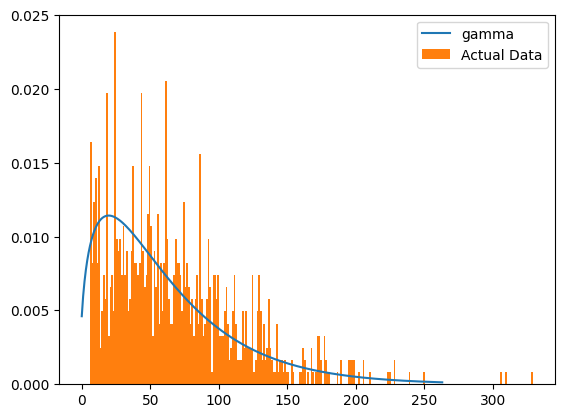

Processing: data/structures/S2.png
(1861, 1393)


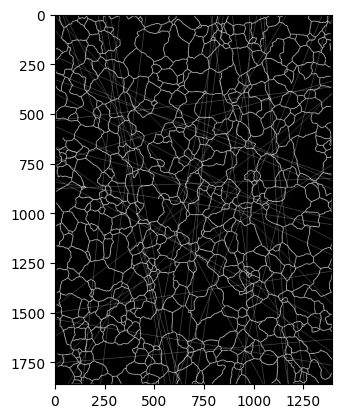

DescribeResult(nobs=1003, minmax=(6, 225), mean=57.39780658025922, variance=1389.9763225294178, skewness=0.9589129839558135, kurtosis=0.8768591379036712)
p value for norm = 1.3666031686814082e-06
p value for alpha = 5.97084418063265e-20
p value for beta = 0.026568234574806504
p value for gamma = 0.01564082494940898
p value for expon = 3.821795705471526e-13
p value for exponnorm = 0.00042122708172067855
p value for t = 1.3669937782768274e-06
p value for erlang = 0.01564225207808329
p value for f = 0.02024956481483543
Best fitting distribution: beta
Best p value: 0.026568234574806504
Parameters for the best fit: (1.1790363238733501, 4.417165219021437, 5.764538942085133, 243.66853983831578)
Mean and variance, calculated from best fit distribution parameters:
57.10187146173276
1496.8874252575645


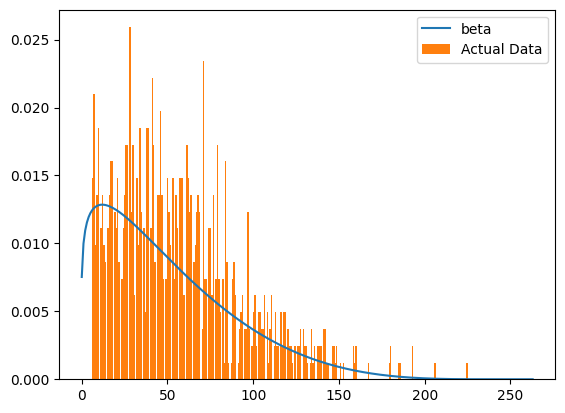

Processing: data/structures/S3.png
(1741, 1221)


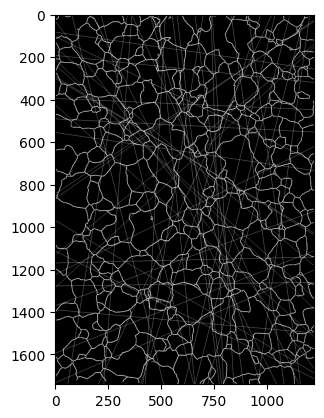

DescribeResult(nobs=1018, minmax=(6, 287), mean=63.55992141453831, variance=1830.3784117932282, skewness=0.9948462466392712, kurtosis=1.0664103842822872)
p value for norm = 3.979915789416657e-08
p value for alpha = 4.041809234763131e-40
p value for beta = 0.08247587088299968
p value for gamma = 0.04584213702715911
p value for expon = 1.4486406735622772e-10
p value for exponnorm = 6.348786015068959e-07
p value for t = 5.37292013287348e-08
p value for erlang = 0.045840104253329295
p value for f = 0.07890169865342711
Best fitting distribution: beta
Best p value: 0.08247587088299968
Parameters for the best fit: (1.1959078185989724, 5.3983400855557955, 5.674800322930915, 317.4501370790507)
Mean and variance, calculated from best fit distribution parameters:
63.246354572348174
1970.1245098217703


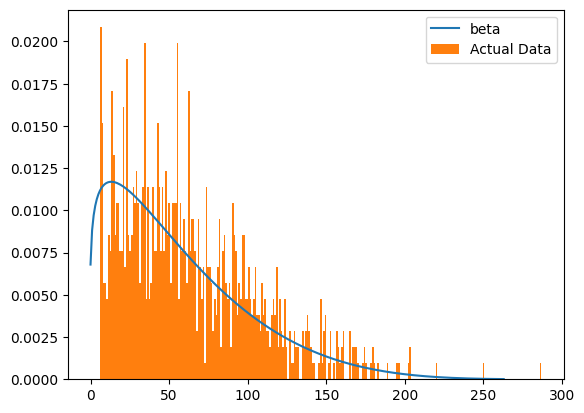

Processing: data/structures/S4.png
(446, 567)


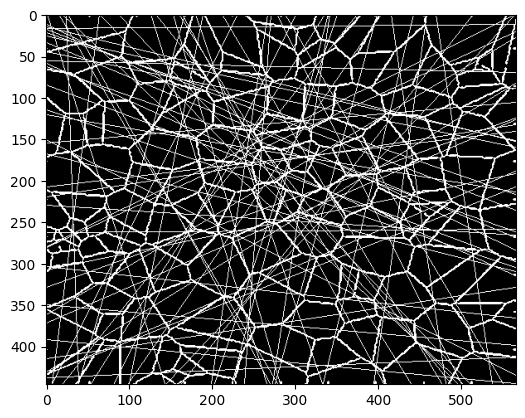

DescribeResult(nobs=1003, minmax=(6, 91), mean=30.009970089730807, variance=238.90608812285697, skewness=0.577115991085455, kurtosis=-0.03277459581400732)
p value for norm = 9.866548120068924e-05
p value for alpha = 0.009166424525725773
p value for beta = 0.01180131816957441
p value for gamma = 0.0006368017877209462
p value for expon = 4.794166145096812e-20
p value for exponnorm = 0.0044531218418068595
p value for t = 9.849876867728968e-05
p value for erlang = 0.0006367919001013276
p value for f = 0.0005652372775434649
Best fitting distribution: beta
Best p value: 0.01180131816957441
Parameters for the best fit: (1.4261762932083955, 3.859362963873143, 5.460840346000493, 90.28733396843994)
Mean and variance, calculated from best fit distribution parameters:
29.822716971977407
255.51791065161643


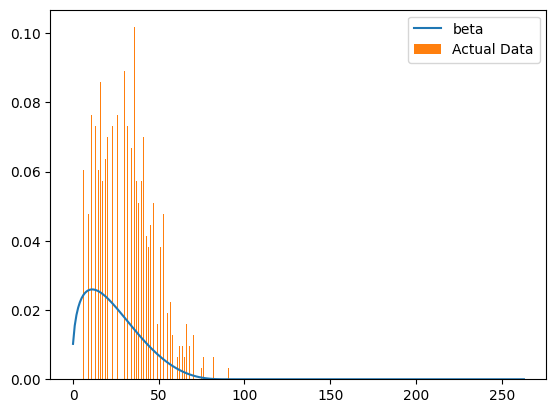

Processing: data/structures/S5.png
(446, 567)


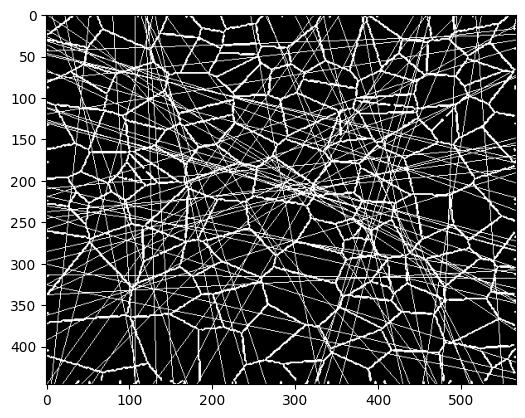

DescribeResult(nobs=1002, minmax=(6, 99), mean=30.55888223552894, variance=252.0949310170867, skewness=0.7677695544678088, kurtosis=0.6275714218353161)
p value for norm = 0.0001917782821253283
p value for alpha = 0.09729433589984782
p value for beta = 0.016904359575849195
p value for gamma = 0.02513343736331064
p value for expon = 4.484979582129411e-26
p value for exponnorm = 0.028112572662194468
p value for t = 0.0006869225507521155
p value for erlang = 0.025133218633332843
p value for f = 0.02534442633792966
Best fitting distribution: alpha
Best p value: 0.09729433589984782
Parameters for the best fit: (6.574232285147562, -68.1108868294906, 633.1187267457603)
Mean and variance, calculated from best fit distribution parameters:
inf
inf


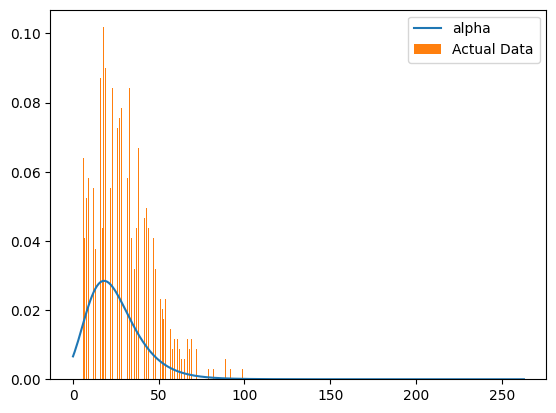

Processing: data/structures/S6.png
(439, 567)


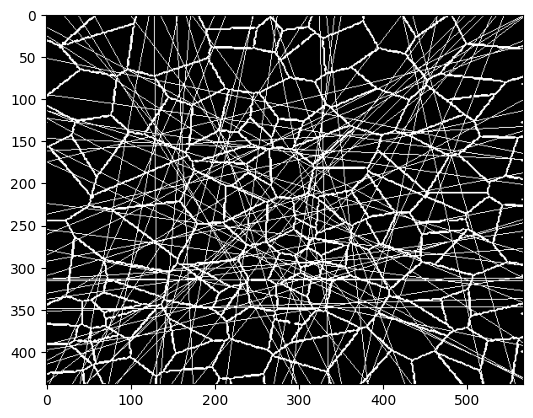

DescribeResult(nobs=1011, minmax=(6, 115), mean=28.81305637982196, variance=260.04917589681816, skewness=0.9388869424427597, kurtosis=1.2400012694296034)
p value for norm = 7.302786043187421e-06
p value for alpha = 0.011281309987801878
p value for beta = 0.0022877535674440687
p value for gamma = 0.0008720258566854691
p value for expon = 1.8651549678321373e-16
p value for exponnorm = 0.005743784907263804
p value for t = 3.863058981541722e-06
p value for erlang = 0.0008721595226914169
p value for f = 0.0008914771184870218
Best fitting distribution: alpha
Best p value: 0.011281309987801878
Parameters for the best fit: (5.31318303716875, -50.15306792865407, 403.916762110019)
Mean and variance, calculated from best fit distribution parameters:
inf
inf


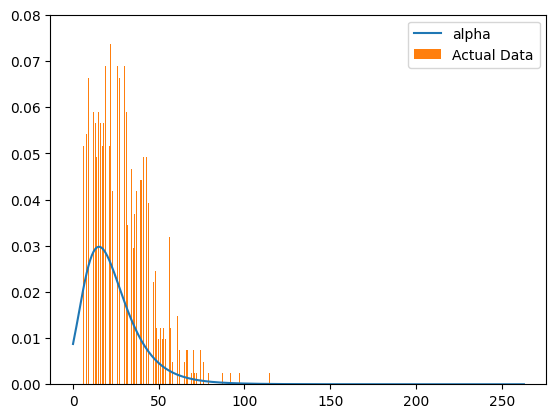

Processing: data/structures/S7.png
(436, 564)


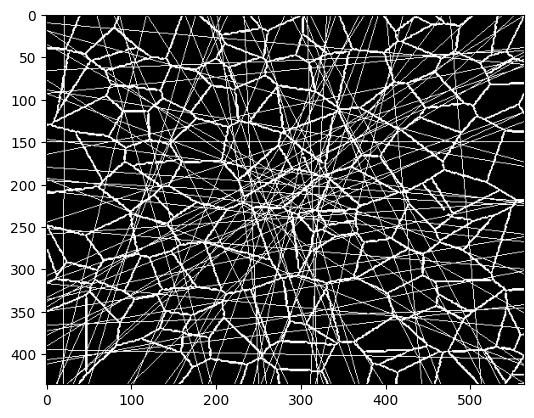

DescribeResult(nobs=1006, minmax=(6, 100), mean=29.283300198807158, variance=233.47687506799997, skewness=0.8225595448815956, kurtosis=0.7244765293734536)
p value for norm = 0.0005444801788577604
p value for alpha = 0.047635521928139246
p value for beta = 0.013090591655080372
p value for gamma = 0.004175191652767761
p value for expon = 6.613429490480428e-22
p value for exponnorm = 0.010682341408209577
p value for t = 0.0002918256275537826
p value for erlang = 0.0041756156698660426
p value for f = 0.004263180789184414
Best fitting distribution: alpha
Best p value: 0.047635521928139246
Parameters for the best fit: (5.946969531906992, -55.78444154708035, 490.9766058267254)
Mean and variance, calculated from best fit distribution parameters:
inf
inf


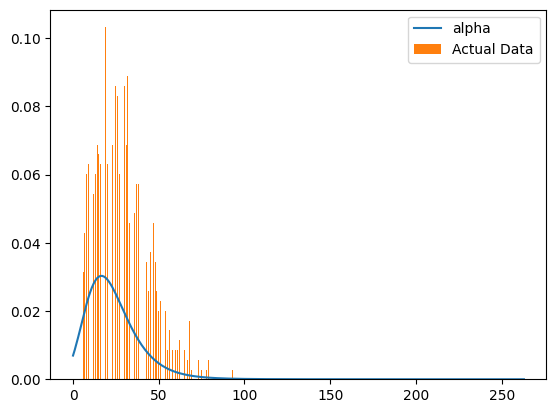

In [28]:
for sample in samples:
    print("Processing: " + sample)
    image_original = iio.imread(uri=sample)
    image = preprocess_image(image_original, verbose=False)
    # remove_islands(image)
    # remove_islands(image, 10)
    remove_islands(image, 20)
    grains, cuts_illustration = collect_grains(image)
    plt.imshow(cuts_illustration, cmap='gray')
    plt.show()
    print(stats.describe(grains))
    best_dist, best_p, best_params = get_best_distribution(grains)
    best_fit_moments(best_dist, best_params)
    illustrate_best_fit(best_dist, best_params)